In [0]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.optim as optim
import seaborn as sns

In [2]:
trainset= torchvision.datasets.MNIST(root='./data',train=True,
                                     download=True,
                                     transform=T.ToTensor())

0it [00:00, ?it/s]

9920512it [00:01, 8778066.83it/s]                            


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 134937.61it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 2202908.05it/s]                            
0it [00:00, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


8192it [00:00, 51487.91it/s]            


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
batch_size=4



In [0]:
trainloader=torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [5]:
dataiter=iter(trainloader)
images,labels= dataiter.next()

print(images.shape)
print(images[0].shape)
print(labels[0].item())

torch.Size([4, 1, 28, 28])
torch.Size([1, 28, 28])
1


In [0]:
def imshow(img, title):

  plt.figure(figsize=(batch_size * 4,4))
  plt.axis('off')
  plt.imshow(np.transpose(img,(1,2,0)))
  plt.title(title)
  plt.show()

In [0]:
def show_batch_images(dataloader):
  images,labels= next(iter(dataloader))
  img= torchvision.utils.make_grid(images)
  imshow(img, title=[str(x.item()) for x in labels])

  return images,labels

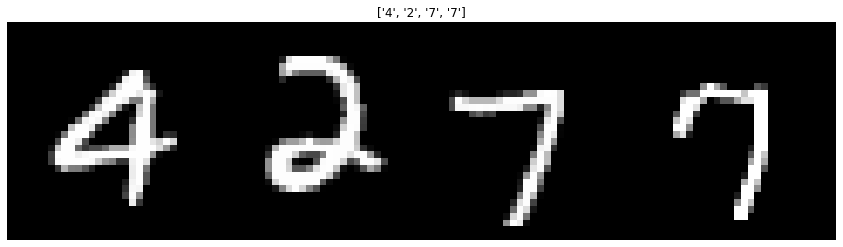

In [8]:
images,labels= show_batch_images(trainloader)

## BatchNorm

In [0]:
class MyNet(nn.Module):
  def __init__(self):
    super(MyNet,self).__init__()
    self.classifier= nn.Sequential(
        nn.Linear(784,48),  # 784= 28 x 28 
        nn.ReLU(),
        nn.Linear(48,24),
        nn.ReLU(),
        nn.Linear(24,10)
    )
  def forward(self,x):
    x=x.view(x.size(0),-1)   #flattnining the input
    x=self.classifier(x)
    return x

In [0]:
class MyNetBN(nn.Module):
  def __init__(self):
    super(MyNetBN,self).__init__()
    self.classifier= nn.Sequential(
        nn.Linear(784,48), # 784= 28 x 28 
        nn.BatchNorm1d(48), 
        nn.ReLU(),
        nn.Linear(48,24),
        nn.BatchNorm1d(24),
        nn.ReLU(),
        nn.Linear(24,10)
    )
  def forward(self,x):
    x=x.view(x.size(0),-1)   #flattnining the input
    x=self.classifier(x)
    return x

In [11]:
model=MyNet()
print(model)

MyNet(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [12]:
model_bn=MyNetBN()
print(model_bn)

MyNetBN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=24, out_features=10, bias=True)
  )
)


In [0]:
batchSize=512

In [0]:
trainloader= torch.utils.data.DataLoader(trainset,batch_size=batchSize,shuffle=True)

In [0]:
loss_fn= nn.CrossEntropyLoss()
opt=optim.SGD(model.parameters(),lr=0.001)
opt_bn= optim.SGD(model_bn.parameters(),lr=0.001)

-0.01771739 0.11189931 -0.031380016 0.11998166


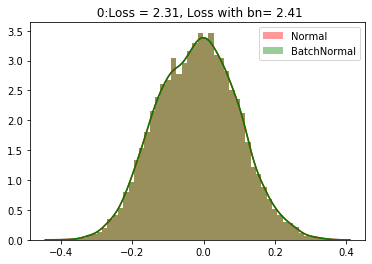

-----------------


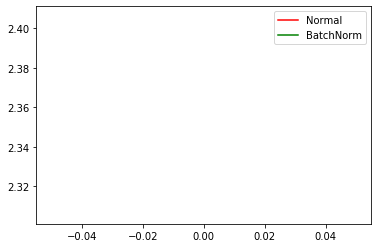

-0.017507836 0.10981912 -0.0012940491 1.0127243


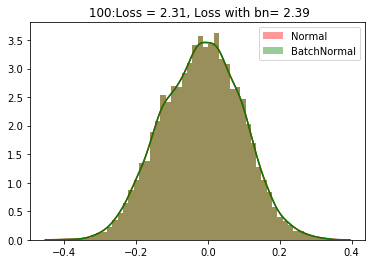

-----------------


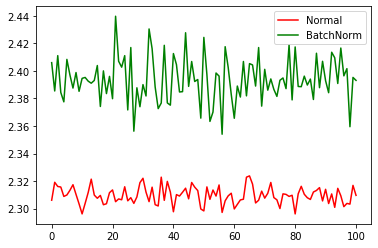

-0.017188186 0.10866163 -0.0049960087 0.9875043


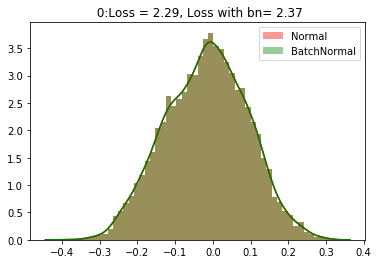

-----------------


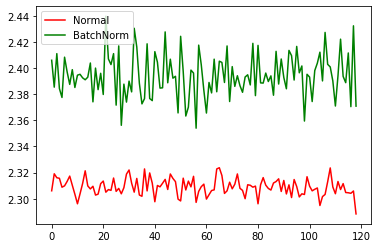

-0.015795814 0.1101739 -0.010360311 1.0095142


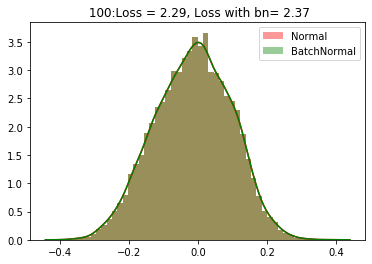

-----------------


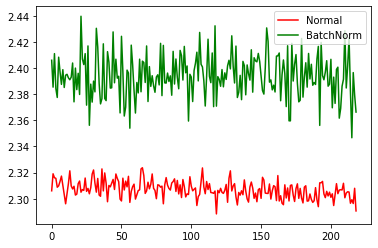

In [16]:
loss_arr=[]
loss_bn_arr=[]
max_epoc =2

for epoch in range(max_epoc):
  for i,data in enumerate(trainloader,0):
    inputs,labels= data
    #trainning for normal NN
    opt.zero_grad()

    outputs= model(inputs)
    loss=loss_fn(outputs,labels)
    loss.backward()
    opt.step()

#training for BatchNormalized Model
    opt_bn.zero_grad()

    outputs= model_bn(inputs)
    loss_bn=loss_fn(outputs,labels)
    loss_bn.backward()
    opt.step()

    loss_arr.append(loss.item())
    loss_bn_arr.append(loss_bn.item())

    if i % 100 ==0:
      inputs= inputs.view(inputs.size(0),-1)
      model.eval()
      model_bn.eval()

      a= model.classifier[0](inputs)
      a=model.classifier[1](a)
      a=model.classifier[2](a)
      a=a.detach().numpy().ravel()  #flatten into single vector 
      sns.distplot(a,kde=True, color='r',label='Normal')

      b= model_bn.classifier[0](inputs)
      b=model_bn.classifier[1](b)
      b=model_bn.classifier[2](b)
      b=model_bn.classifier[3](b)
      b=model_bn.classifier[4](b)
      b=b.detach().numpy().ravel()  #faltten into vector

      sns.distplot(a,kde=True, color='g',label='BatchNormal')

      print(np.mean(a), np.std(a), np.mean(b),np.std(b))

      plt.title(" %d:Loss = %0.2f, Loss with bn= %0.2f" %(i, loss.item(),loss_bn.item()))
      plt.legend()
      plt.show()
      plt.pause(0.5)

      model.train()
      model_bn.train()

      print("-----------------")

      plt.plot(loss_arr,'r',label='Normal')
      plt.plot(loss_bn_arr,'g',label='BatchNorm')
      plt.legend()
      plt.show()

## Batch2D Normalization

In [0]:
class CNN_BB(nn.Module):
  def __init__(self):
    super(MyNetBN,self).__init__()
    self.features=nn.Sequential(
        nn.Conv2d(1,3,5),
        nn.ReLU(),
        nn.AvgPool2d(2,stride=2),
        nn.Conv2d(3,6,3),
        nn.BatchNorm2d(6)
    )
    self.feature1 = nn.Sequential(
        nn.ReLU(),
        nn.AvgPool2d(2,stride=2)
    )

    self.classifier= nn.Sequential(
        nn.Linear(150,25),
        nn.ReLU(),
        nn.Linear(25,10)
    )

  def forward(self,x):
    x= self.features(x)
    x=self.features1(x)
    x=x.view(x.size(0),-1)
    X=self.classifier(x)
    return X

## *DropOut*

It uses to avoid overfitting, and regularization technique that " drops out" or "deactivates" few neurons network randomly in order to avoid that problem of overfitting

In [0]:
N=25
noise= 0.3

X_train = torch.unsqueeze(torch.linspace(-1,1,N),1)
Y_train= X_train + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

X_test = torch.unsqueeze(torch.linspace(-1,1,N),1)
Y_test= X_test + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

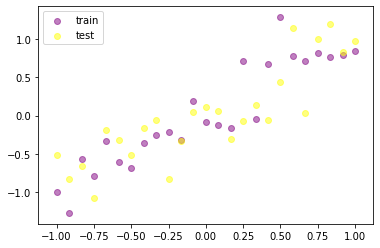

In [19]:
plt.scatter(X_train.data.numpy(),Y_train.data.numpy(),c='purple',alpha=0.5, label='train')
plt.scatter(X_test.data.numpy(),Y_test.data.numpy(),c='yellow',alpha=0.5,label='test')
plt.legend()
plt.show()

In [0]:
N_h= 100

model= torch.nn.Sequential(
    torch.nn.Linear(1,N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h,N_h),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h,1)
)

model_dropout= torch.nn.Sequential(
    torch.nn.Linear(1,N_h),
    torch.nn.Dropout(0.3), # 0.5 is dropout
    torch.nn.ReLU(),
    torch.nn.Linear(N_h,N_h),
    torch.nn.Dropout(0.3),
    torch.nn.ReLU(),
    torch.nn.Linear(N_h,1)
)

In [0]:
opt= torch.optim.Adam(model.parameters(),lr=0.01)
opt_dropout = torch.optim.Adam(model_dropout.parameters(),lr=0.01)
loss_fn = torch.nn.MSELoss()

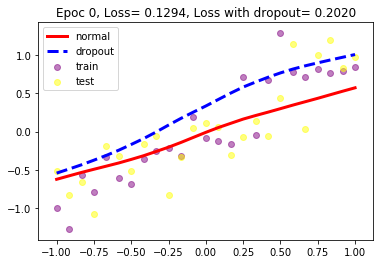

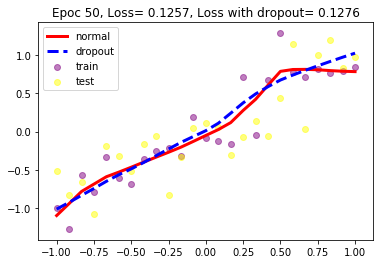

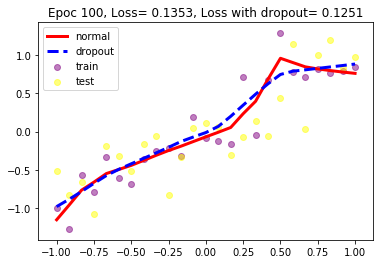

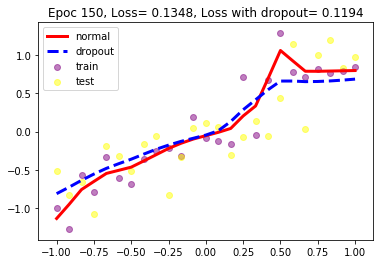

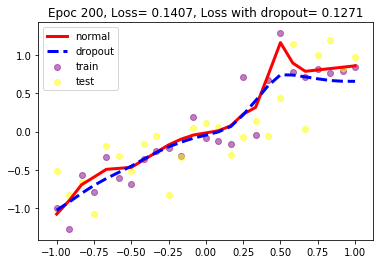

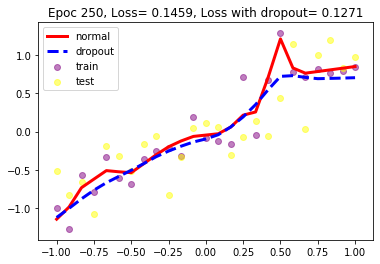

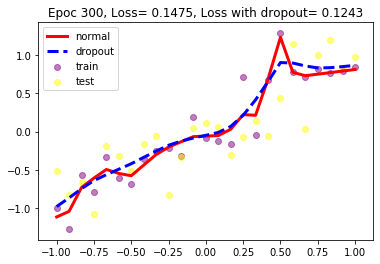

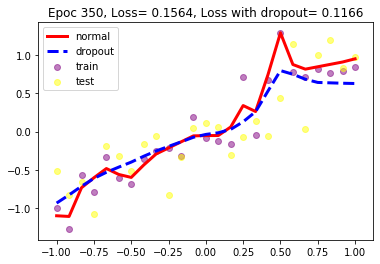

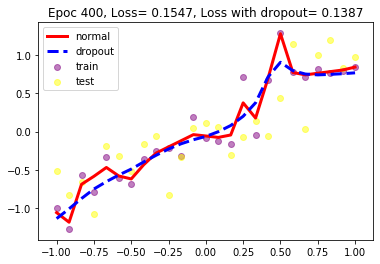

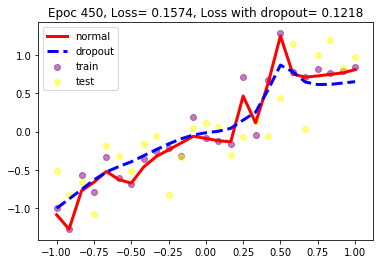

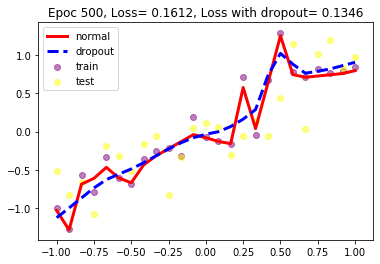

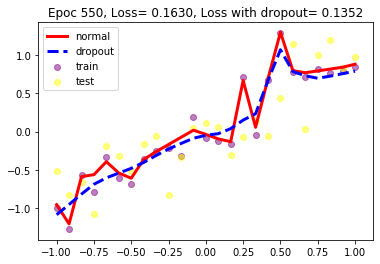

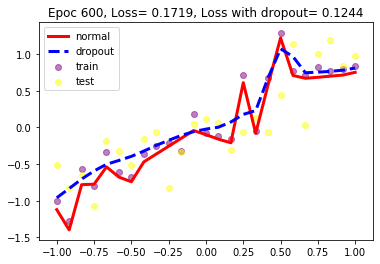

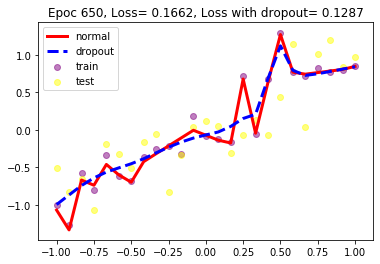

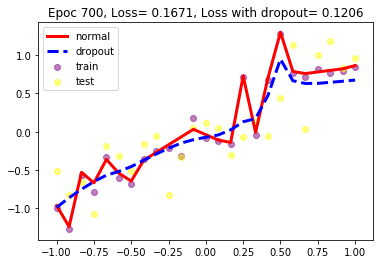

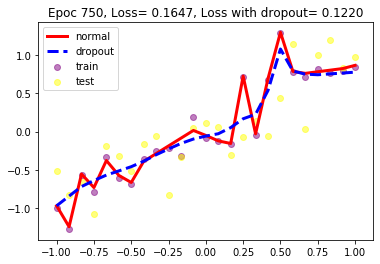

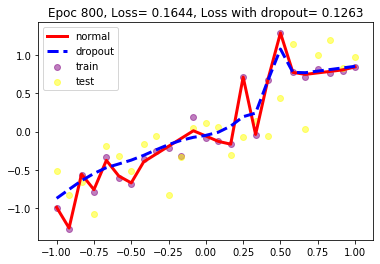

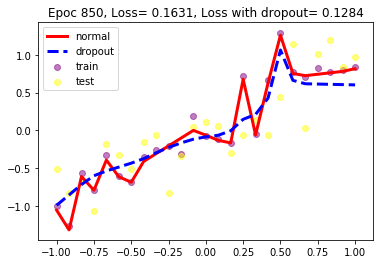

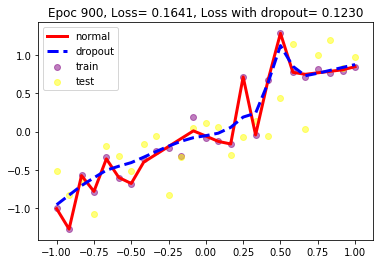

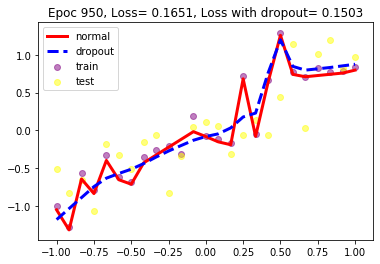

In [31]:
max_epochs= 1000

for epoch in range(max_epochs):
  pred = model(X_train)
  loss= loss_fn(pred,Y_train)
  opt.zero_grad()
  loss.backward()
  opt.step()

  pred_dropout= model_dropout(X_train)
  loss_dropout= loss_fn(pred_dropout,Y_train)
  opt_dropout.zero_grad()
  loss_dropout.backward()
  opt_dropout.step()

  if epoch % 50 == 0:
    model.eval()
    model_dropout.eval()   #here dropout does not drop neuron instead multiply with scaler value to the prob. set weights of their own neurons

    test_pred = model(X_test)
    test_loss= loss_fn(test_pred,Y_test)

    test_pred_dropout= model_dropout(X_test)
    test_loss_dropout=  loss_fn(test_pred_dropout,Y_test)

    plt.scatter(X_train.data.numpy(), Y_train.data.numpy(), c='purple',alpha=0.5,label='train')
    
    plt.scatter(X_test.data.numpy(), Y_test.data.numpy(), c='yellow',alpha=0.5,label='test')
    plt.plot(X_test.data.numpy(), test_pred.data.numpy(),'r-',lw=3,label='normal')
    plt.plot(X_test.data.numpy(), test_pred_dropout.data.numpy(),'b--',lw=3,label='dropout')

    plt.title('Epoc %d, Loss= %0.4f, Loss with dropout= %0.4f' %(epoch, test_loss, test_loss_dropout))

    plt.legend()

    model.train()
    model_dropout.train()

    plt.pause(0.05)